In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

https://github.com/nisode/MSDS/tree/main/Deep%20Learning%20Final

# Task

This is a multiclassification task initialized published by Intel as a challenge.

This Data contains around 25k images of size 150pix150pi under 6 categories.
* 'buildings' -> 0,
* 'forest' -> 1
* 'glacier' -> 2
* 'mountain' -> 3
* 'sea' -> 4
* 'street' -> 5 

There are around 14k images in Train, 3k in Test and 7k in Prediction.

# Load Data

Let's first load the data and split the training into train and validation. Validation is set to a standard 0.2/0.8 split.

Test needs to set shuffle for false for comparison later.

In [171]:
import tensorflow as tf

train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
test_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         validation_split=0.2,
                                                         subset="training",
                                                         seed=44,
                                                         image_size=(150, 150),
                                                         batch_size=32,
                                                         label_mode='categorical')

valid_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         validation_split=0.2,
                                                         subset="validation",
                                                         seed=44,
                                                         image_size=(150, 150),
                                                         batch_size=32,
                                                         label_mode='categorical')

test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                         seed=44,
                                                         image_size=(150, 150),
                                                         batch_size=32,
                                                         label_mode='categorical',
                                                         shuffle=False)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


For sanity check, file sizes match up with 14k files in train and 3k files in test.

# EDA

Let's get the label names from the directory folders.

In [6]:
labels = os.listdir("../input/intel-image-classification/seg_train/seg_train") 
labels

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

Next let's count how many of each label there are to see if the data is imbalanced. Let's visualize this count as well.

In [30]:
label_counts = {}
for label in labels:
    label_counts[label] = len(list(os.listdir(f"../input/intel-image-classification/seg_train/seg_train/{label}")))

counts_df = pd.DataFrame.from_dict(label_counts, orient="index", columns=["Counts"])
counts_df

,Counts
mountain,2512
street,2382
buildings,2191
sea,2274
forest,2271
glacier,2404


Text(0.5, 1.0, 'Counts per Label (Train)')

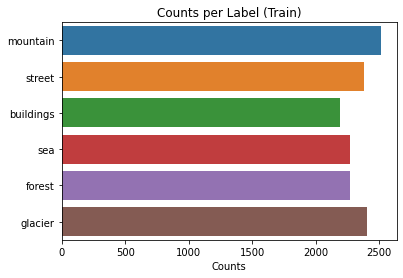

In [182]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.barplot(x=counts_df.Counts, y=counts_df.index, orient="h")
plt.title("Counts per Label (Train)")

Looks pretty balanced and the pie chart below confirms the percentages are very close. Buildings has the least amount of pictures while mountains has marginally the most.

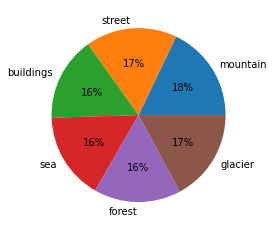

In [73]:
plt.pie(counts_df.Counts, labels=counts_df.index, autopct='%.0f%%')
plt.show()

Let's also check to see that the test labels are also equally balanced.

In [36]:
test_label_counts = {}
for label in labels:
    test_label_counts[label] = len(list(os.listdir(f"../input/intel-image-classification/seg_test/seg_test/{label}")))

test_counts_df = pd.DataFrame.from_dict(test_label_counts, orient="index", columns=["Counts"])
test_counts_df

,Counts
mountain,525
street,501
buildings,437
sea,510
forest,474
glacier,553


Text(0.5, 1.0, 'Counts per Label (Test)')

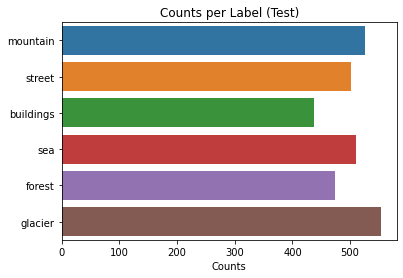

In [181]:
sns.barplot(x=test_counts_df.Counts, y=test_counts_df.index, orient="h")
plt.title("Counts per Label (Test)")

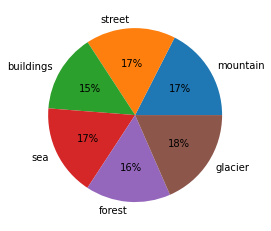

In [74]:
plt.pie(test_counts_df.Counts, labels=test_counts_df.index, autopct='%.0f%%')
plt.show()

Seems to be just about equally balanced like the training set. There are one again least amount of buildings.

Let's take a look at some of the immages in the dataset.

In [96]:
class_names = train_data.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

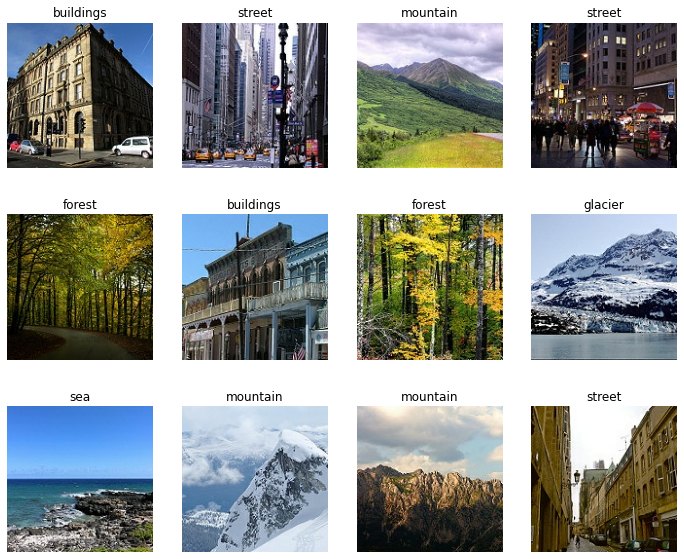

In [100]:
plt.figure(figsize=(12, 10))
for images, labels in train_data.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(np.array(labels[i]))])
    plt.axis("off")

From these twelve images, it's easy to imagine where a neural network will have trouble. Street and buildings look very similar as well as mountains and glaciers. I would have a hard time telling some of those apart too as streets have buildings and mountians also have glaciers. It will definitely cause some problems.

# Model Architecture

Let's build a simple CNN to try to classify our images.

In [102]:
from keras.models import Sequential
from tensorflow.keras import layers

General explanation of design choices:
1. Conv2D in 3x3 tends to be just as effective as larger filters like 5x5
2. Relu tends to work well with just about everything so we are keeping it here
3. Padding is same so we don't shrink our image
4. MaxPooling in a 2x2 to help with overfitting and reducing variables
5. BatchNormalization to normalize data to make it more stable
6. Dropout to also avoid overfitting
7. Softmax output is necessary for multiclass classification

In [122]:
model1 = Sequential([
    layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(150,150,3), padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 75, 75, 16)        64        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 37, 37, 64)       

We will use Adam for optimatization as it tends to work well with a lot of things and a standard learning rate of 0.0001 to start off.

The loss will be categorical crossentropy as that is the loss function used for multiclass classification and we will only be concerned with accuracy this time.

In [127]:
model1.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = .0001),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

# Results

We're gonna run every model we make for 10 epochs and compare the results after modifications.

In [128]:
history_model1 = model1.fit(train_data, validation_data = valid_data, epochs = 10)

Epoch 1/10
351/351 [==============================] - 48s 134ms/step - loss: 1.1216 - accuracy: 0.5991 - val_loss: 0.8293 - val_accuracy: 0.6939
Epoch 2/10
351/351 [==============================] - 12s 34ms/step - loss: 0.6542 - accuracy: 0.7584 - val_loss: 0.7912 - val_accuracy: 0.7110
Epoch 3/10
351/351 [==============================] - 12s 34ms/step - loss: 0.4440 - accuracy: 0.8432 - val_loss: 0.6875 - val_accuracy: 0.7630
Epoch 4/10
351/351 [==============================] - 11s 32ms/step - loss: 0.3132 - accuracy: 0.8911 - val_loss: 0.7431 - val_accuracy: 0.7491
Epoch 5/10
351/351 [==============================] - 11s 32ms/step - loss: 0.2227 - accuracy: 0.9270 - val_loss: 0.7001 - val_accuracy: 0.7716
Epoch 6/10
351/351 [==============================] - 12s 33ms/step - loss: 0.1698 - accuracy: 0.9439 - val_loss: 0.6991 - val_accuracy: 0.7830
Epoch 7/10
351/351 [==============================] - 12s 33ms/step - loss: 0.1315 - accuracy: 0.9605 - val_loss: 0.6819 - val_accuracy

This will be the helper history plotting function for every model we do.

In [133]:
def metrics_plot(history):
    xs = np.arange(1, len(history['loss'])+1)
    plt.figure(figsize=[16,4])
    
    plt.subplot(1,2,1)
    plt.plot(xs, history['loss'], label='Training')
    plt.plot(xs, history['val_loss'], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('Loss') 
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(xs, history['accuracy'], label='Training')
    plt.plot(xs, history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch') 
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    
    plt.show()

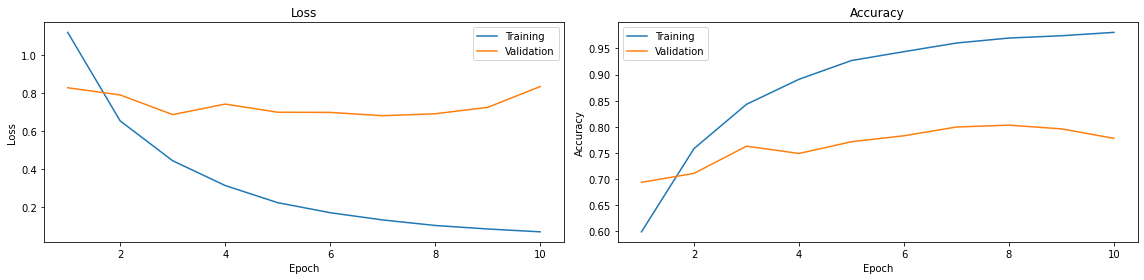

In [135]:
metrics_plot(history_model1.history)

Seems to maybe overshoot a little bit. Let's try lowering the learning rate to 0.00001

In [129]:
model2 = Sequential([
    layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(150,150,3), padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])
model2.summary()
model2.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = .00001),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 75, 75, 16)        64        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 37, 37, 64)       

In [130]:
history_model2 = model2.fit(train_data, validation_data = valid_data, epochs = 10)

Epoch 1/10
351/351 [==============================] - 13s 34ms/step - loss: 1.4577 - accuracy: 0.4642 - val_loss: 1.0465 - val_accuracy: 0.6055
Epoch 2/10
351/351 [==============================] - 11s 32ms/step - loss: 1.0589 - accuracy: 0.6085 - val_loss: 0.9354 - val_accuracy: 0.6450
Epoch 3/10
351/351 [==============================] - 11s 32ms/step - loss: 0.9115 - accuracy: 0.6640 - val_loss: 0.8697 - val_accuracy: 0.6707
Epoch 4/10
351/351 [==============================] - 11s 32ms/step - loss: 0.8158 - accuracy: 0.7036 - val_loss: 0.8299 - val_accuracy: 0.6853
Epoch 5/10
351/351 [==============================] - 11s 32ms/step - loss: 0.7252 - accuracy: 0.7358 - val_loss: 0.7961 - val_accuracy: 0.6939
Epoch 6/10
351/351 [==============================] - 11s 32ms/step - loss: 0.6526 - accuracy: 0.7712 - val_loss: 0.7715 - val_accuracy: 0.7124
Epoch 7/10
351/351 [==============================] - 11s 32ms/step - loss: 0.6039 - accuracy: 0.7837 - val_loss: 0.7455 - val_accuracy:

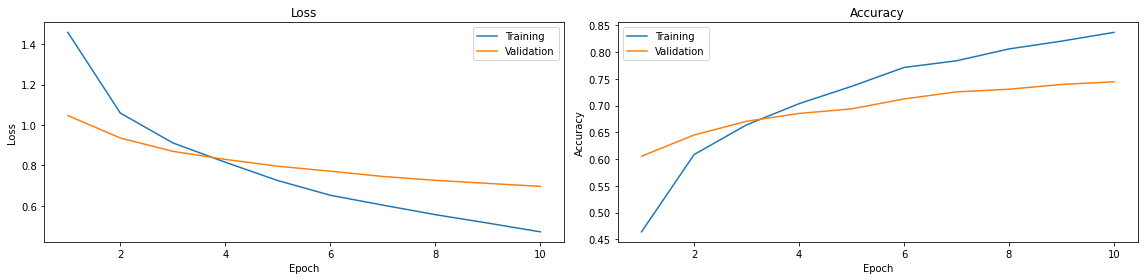

In [136]:
metrics_plot(history_model2.history)

Validation accuracy still going up after end of 10 epochs which means it could be trained further, but for 10 epochs limit per model, this learning rate is too low.

Let's see what a higher learning rate of 0.001 would look like.

In [131]:
model3 = Sequential([
    layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(150,150,3), padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])
model3.summary()
model3.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = .001),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 75, 75, 16)        64        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 37, 37, 64)       

In [132]:
history_model3 = model3.fit(train_data, validation_data = valid_data, epochs = 10)

Epoch 1/10
351/351 [==============================] - 14s 38ms/step - loss: 1.1426 - accuracy: 0.5882 - val_loss: 1.0111 - val_accuracy: 0.6768
Epoch 2/10
351/351 [==============================] - 13s 35ms/step - loss: 0.7973 - accuracy: 0.7024 - val_loss: 0.7665 - val_accuracy: 0.7420
Epoch 3/10
351/351 [==============================] - 13s 36ms/step - loss: 0.6388 - accuracy: 0.7620 - val_loss: 0.6429 - val_accuracy: 0.7883
Epoch 4/10
351/351 [==============================] - 12s 34ms/step - loss: 0.5310 - accuracy: 0.7985 - val_loss: 0.6154 - val_accuracy: 0.8022
Epoch 5/10
351/351 [==============================] - 13s 36ms/step - loss: 0.4410 - accuracy: 0.8344 - val_loss: 0.6804 - val_accuracy: 0.7894
Epoch 6/10
351/351 [==============================] - 12s 34ms/step - loss: 0.3934 - accuracy: 0.8508 - val_loss: 0.6770 - val_accuracy: 0.7897
Epoch 7/10
351/351 [==============================] - 14s 38ms/step - loss: 0.3381 - accuracy: 0.8736 - val_loss: 0.7875 - val_accuracy:

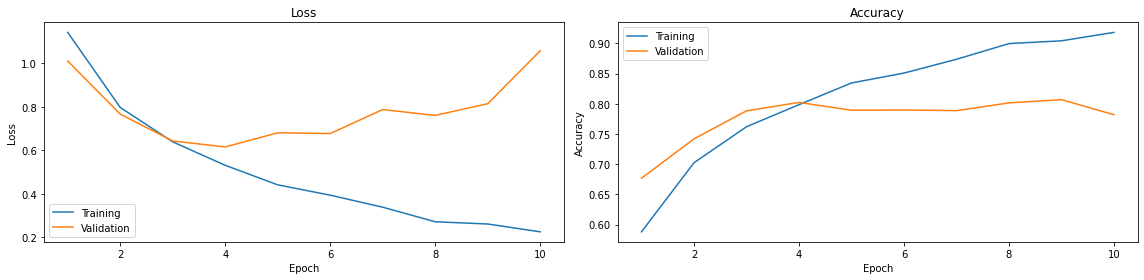

In [137]:
metrics_plot(history_model3.history)

Doesn't overshoot quite as much as I would have expected but as you can see from the loss line that this is a bit unstable.

Let's try the original model, but let's first rescale the data by dividing by 255.

In [138]:
model4 = Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(16, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])
model4.summary()
model4.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = .0001),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 75, 75, 16)        64        
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 37, 37, 32)      

In [139]:
history_model4 = model4.fit(train_data, validation_data = valid_data, epochs = 10)

Epoch 1/10
351/351 [==============================] - 12s 33ms/step - loss: 1.0697 - accuracy: 0.6275 - val_loss: 2.4504 - val_accuracy: 0.4113
Epoch 2/10
351/351 [==============================] - 11s 32ms/step - loss: 0.5984 - accuracy: 0.7825 - val_loss: 0.6607 - val_accuracy: 0.7691
Epoch 3/10
351/351 [==============================] - 13s 36ms/step - loss: 0.3949 - accuracy: 0.8585 - val_loss: 0.6270 - val_accuracy: 0.7872
Epoch 4/10
351/351 [==============================] - 12s 34ms/step - loss: 0.2691 - accuracy: 0.9068 - val_loss: 0.6647 - val_accuracy: 0.7990
Epoch 5/10
351/351 [==============================] - 11s 32ms/step - loss: 0.1915 - accuracy: 0.9366 - val_loss: 0.6525 - val_accuracy: 0.8026
Epoch 6/10
351/351 [==============================] - 12s 33ms/step - loss: 0.1459 - accuracy: 0.9538 - val_loss: 0.7377 - val_accuracy: 0.7847
Epoch 7/10
351/351 [==============================] - 12s 33ms/step - loss: 0.1124 - accuracy: 0.9649 - val_loss: 0.6929 - val_accuracy:

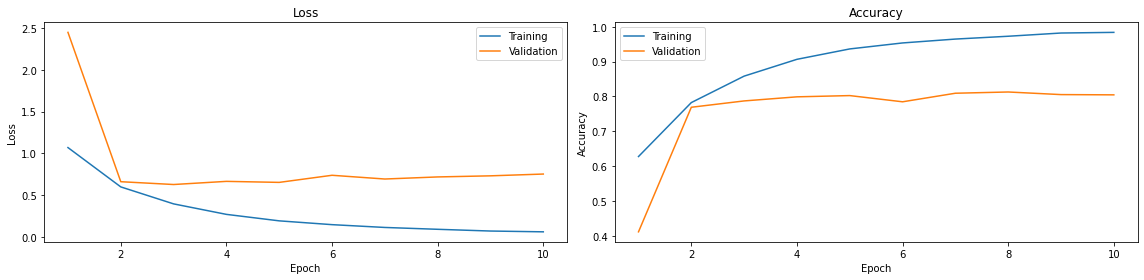

In [140]:
metrics_plot(history_model4.history)

Well it seems to reach it's accuracy limit quickly, but there doesn't seem to be much improvement past 0.8 in these models so far. That being said all the next models will have rescaling as it seems to help reach the threshold faster.

Although 3x3 tends to be more recommended, let's try all 5x5 filters instead and see if there's a significant difference.

In [141]:
model5 = Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])
model5.summary()
model5.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = .0001),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 150, 150, 16)      1216      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 75, 75, 16)        64        
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 75, 75, 32)        12832     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 37, 37, 32)      

In [142]:
history_model5 = model5.fit(train_data, validation_data = valid_data, epochs = 10)

Epoch 1/10
351/351 [==============================] - 13s 36ms/step - loss: 1.0536 - accuracy: 0.6238 - val_loss: 4.2289 - val_accuracy: 0.2630
Epoch 2/10
351/351 [==============================] - 12s 34ms/step - loss: 0.5933 - accuracy: 0.7865 - val_loss: 0.7692 - val_accuracy: 0.7274
Epoch 3/10
351/351 [==============================] - 12s 33ms/step - loss: 0.4054 - accuracy: 0.8508 - val_loss: 0.7173 - val_accuracy: 0.7627
Epoch 4/10
351/351 [==============================] - 13s 35ms/step - loss: 0.2902 - accuracy: 0.8964 - val_loss: 0.7375 - val_accuracy: 0.7694
Epoch 5/10
351/351 [==============================] - 12s 34ms/step - loss: 0.2137 - accuracy: 0.9300 - val_loss: 0.6019 - val_accuracy: 0.8054
Epoch 6/10
351/351 [==============================] - 12s 34ms/step - loss: 0.1557 - accuracy: 0.9507 - val_loss: 0.6148 - val_accuracy: 0.8076
Epoch 7/10
351/351 [==============================] - 13s 35ms/step - loss: 0.1268 - accuracy: 0.9604 - val_loss: 0.7107 - val_accuracy:

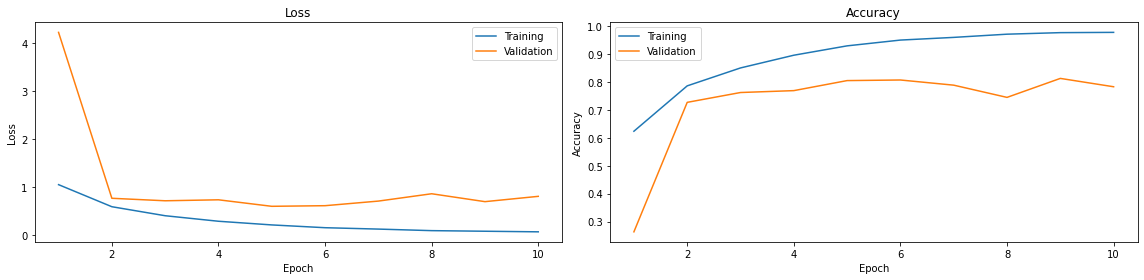

In [147]:
metrics_plot(history_model5.history)

The story seems to be just about the same with all 5x5s. There's a small improvement in accuracy but also an increase in number of parameters in the model. Let's see if only one 5x5 filter, instead of 3 5x5s, will do anything to change the result.

In [144]:
model6 = Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(16, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])
model6.summary()
model6.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = .0001),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 150, 150, 16)      1216      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 75, 75, 16)        64        
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 37, 37, 32)      

In [145]:
history_model6 = model6.fit(train_data, validation_data = valid_data, epochs = 10)

Epoch 1/10
351/351 [==============================] - 12s 33ms/step - loss: 1.0455 - accuracy: 0.6220 - val_loss: 2.1151 - val_accuracy: 0.4298
Epoch 2/10
351/351 [==============================] - 12s 34ms/step - loss: 0.6064 - accuracy: 0.7736 - val_loss: 0.7079 - val_accuracy: 0.7459
Epoch 3/10
351/351 [==============================] - 12s 34ms/step - loss: 0.3900 - accuracy: 0.8609 - val_loss: 0.6598 - val_accuracy: 0.7826
Epoch 4/10
351/351 [==============================] - 12s 34ms/step - loss: 0.2730 - accuracy: 0.9092 - val_loss: 0.7195 - val_accuracy: 0.7698
Epoch 5/10
351/351 [==============================] - 11s 31ms/step - loss: 0.1960 - accuracy: 0.9324 - val_loss: 0.7638 - val_accuracy: 0.7630
Epoch 6/10
351/351 [==============================] - 11s 31ms/step - loss: 0.1428 - accuracy: 0.9583 - val_loss: 0.6717 - val_accuracy: 0.8015
Epoch 7/10
351/351 [==============================] - 12s 32ms/step - loss: 0.1129 - accuracy: 0.9655 - val_loss: 0.7032 - val_accuracy:

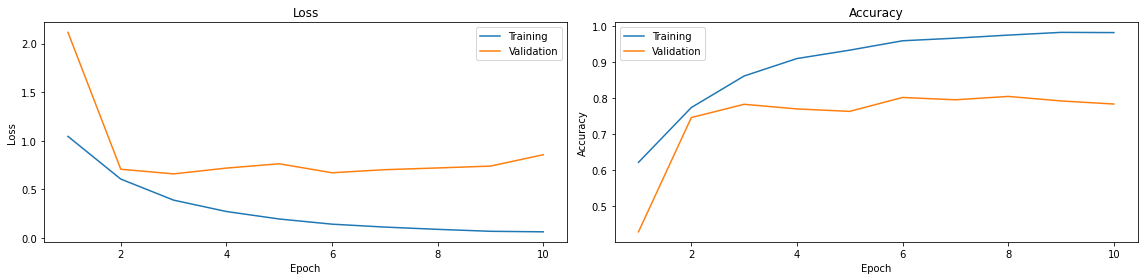

In [146]:
metrics_plot(history_model6.history)

There doesn't seem to be much change even with changing it to only one 5x5 instead of all. 

Let's see if doubling the amount of filters and increasing the amount of parameters by a lot will help.

In [148]:
model7 = Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(32, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])
model7.summary()
model7.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = .0001),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 37, 37, 64)      

In [149]:
history_model7 = model7.fit(train_data, validation_data = valid_data, epochs = 10)

Epoch 1/10
351/351 [==============================] - 69s 37ms/step - loss: 1.0315 - accuracy: 0.6478 - val_loss: 5.4555 - val_accuracy: 0.3190
Epoch 2/10
351/351 [==============================] - 12s 34ms/step - loss: 0.4803 - accuracy: 0.8259 - val_loss: 0.9819 - val_accuracy: 0.6935
Epoch 3/10
351/351 [==============================] - 12s 34ms/step - loss: 0.2891 - accuracy: 0.8958 - val_loss: 0.6420 - val_accuracy: 0.7915
Epoch 4/10
351/351 [==============================] - 13s 36ms/step - loss: 0.1908 - accuracy: 0.9320 - val_loss: 0.5940 - val_accuracy: 0.8029
Epoch 5/10
351/351 [==============================] - 12s 34ms/step - loss: 0.1224 - accuracy: 0.9611 - val_loss: 0.8032 - val_accuracy: 0.7840
Epoch 6/10
351/351 [==============================] - 13s 36ms/step - loss: 0.0926 - accuracy: 0.9724 - val_loss: 0.7055 - val_accuracy: 0.8215
Epoch 7/10
351/351 [==============================] - 13s 35ms/step - loss: 0.0726 - accuracy: 0.9773 - val_loss: 0.8495 - val_accuracy:

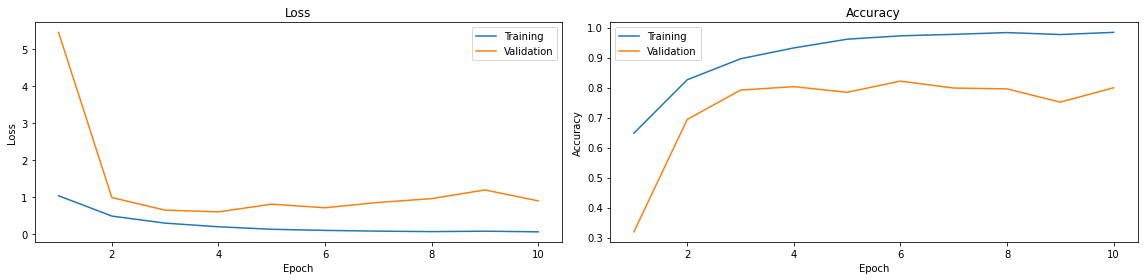

In [151]:
metrics_plot(history_model7.history)

This one had the highest max validation accuracy within an epoch so for now I will pick this as the best model. Either way all the graphs look pretty similar.

Let's try some preprocessing on the images by adding in jittering by adding in random flips, random rotation, and random zoom. 

In [152]:
model8 = Sequential([
    layers.RandomFlip("horizontal", input_shape=(150, 150, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(6, activation='softmax')
])
model8.summary()
model8.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = .0001),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 150, 150, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 150, 150, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 150, 150, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 75, 75, 32)      

In [153]:
history_model8 = model8.fit(train_data, validation_data = valid_data, epochs = 10)

Epoch 1/10
351/351 [==============================] - 16s 41ms/step - loss: 1.1017 - accuracy: 0.6119 - val_loss: 4.7436 - val_accuracy: 0.3435
Epoch 2/10
351/351 [==============================] - 13s 36ms/step - loss: 0.8504 - accuracy: 0.6841 - val_loss: 1.1004 - val_accuracy: 0.6319
Epoch 3/10
351/351 [==============================] - 14s 39ms/step - loss: 0.7698 - accuracy: 0.7173 - val_loss: 0.9755 - val_accuracy: 0.6842
Epoch 4/10
351/351 [==============================] - 13s 37ms/step - loss: 0.7240 - accuracy: 0.7346 - val_loss: 1.1365 - val_accuracy: 0.6543
Epoch 5/10
351/351 [==============================] - 14s 39ms/step - loss: 0.6763 - accuracy: 0.7525 - val_loss: 0.9339 - val_accuracy: 0.7006
Epoch 6/10
351/351 [==============================] - 13s 36ms/step - loss: 0.6389 - accuracy: 0.7662 - val_loss: 0.9243 - val_accuracy: 0.7071
Epoch 7/10
351/351 [==============================] - 13s 36ms/step - loss: 0.6075 - accuracy: 0.7775 - val_loss: 0.8619 - val_accuracy:

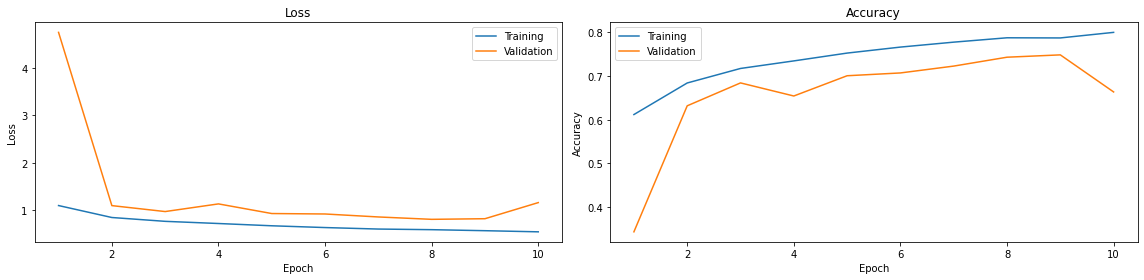

In [154]:
metrics_plot(history_model8.history)

Adding in random noise made it much worse. Although it is preventing overfitting as the accuracy levels are quite low in comparison, the model doesn't seem to be improving very much and even fell off a cliff in the end. It doesn't look like adding in random noise will be a good solution for this model.

Here are the summary results of all tested models:

| model | change | accuracy | val_accuracy | max_val |
| --- | --- | --- | --- | --- |
| model1 | baseline | 0.9809 |  0.7780 | 0.8033 |
| model2 | learning rate 1e-5 | 0.8367 | 0.7445 | 0.7445 |
| model3 | learning rate 1e-3 | 0.9182 | 0.7819 | 0.8068 |
| model4 | rescaling 1/255 | 0.9841 | 0.8047 | 0.8129 |
| model5 | all 5x5 filters | 0.9784 | 0.7833 | 0.8133 | 
| model6 | one 5x5, two 3x3 | 0.9809 | 0.7833 | 0.8043 |
| model7 | double parameters | 0.9839 | 0.7994 | 0.8215 |
| model8 | random flip + rotation| 0.7999 | 0.6636 | 0.7484 |


As we can see that outside of the low learning rate of 1e-5 and the random noise addition, these models performed similarly. The low learning rate looked like it could definitely perform better htan it showed if given more epochs but with only 10 epochs, it was learning too slowly. Since double filters had the highest max_val in the the epoch cycle and seemed to be relatively stable, I will be going with that to see what results would have produced on the test model.

# Conclusion

To see the final results of the model exploration, let's evaluate the test_data and see what the accuracy would be on model7 the double filter model.

In [167]:
model7.evaluate(test_data)

94/94 [==============================] - 3s 28ms/step - loss: 1.0969 - accuracy: 0.7583


[1.0968749523162842, 0.7583333253860474]

The accuracy on unseen test_data is about 76%. Definitely not as good we might expect. Maybe if we put some early stopping on the model it would have performed better.

Let's see what a confusion matrix of the actual test labels and predicted labels would look like to see what the model had trouble with.

In [176]:
preds = model7.predict(test_data).argmax(axis=1)
preds

array([0, 4, 0, ..., 3, 4, 5])

In [178]:
test_label = np.concatenate([y for x, y in test_data], axis=0).argmax(axis=1)
test_label 

array([0, 0, 0, ..., 5, 5, 5])

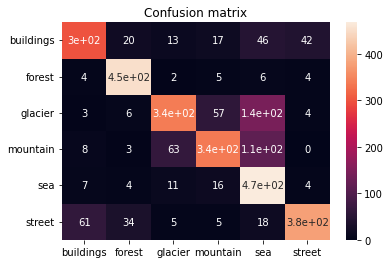

In [180]:
from sklearn.metrics import confusion_matrix

conf_matx = confusion_matrix(test_label, preds)
ax = plt.axes()
sns.heatmap(conf_matx, 
            annot=True,  
            xticklabels=class_names, 
            yticklabels=class_names, 
            ax = ax)
ax.set_title('Confusion matrix')
plt.show()

As expected, the model was confused with buildings and streets. It was also confused with mountain and glacier and surprisingly very confused with sea and mountain and sea and glacier. Those mountain and glacier pictures must have also contained a lot of water and had similar color schemes. I do find it interesting that forest and street had some confusion as well forest and buildings, but there may have been buildings with a lot of plant life and greenery. Sea and buildings doesn't make too much sense but maybe some seaside buildings? The confusion matrix doesn't make it seem like the model did a terrible job. I think in the future I should try some lower learning rates and for longer epochs as higher learning rates definitely overshoot too fast. I think maybe we could do with some changes in architecture such as more convultional layers or higher dropouts. Adding random jittering was not helpful for the models I used. Early stopping could have helped increased model performance as well.